In [1]:
from models import build_bayesian_linear_regression_model
from utils import prepare_transformed_dataset, inverse_logit_transform
%load_ext autoreload
%autoreload 2

from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, accuracy_score

import arviz as az
import seaborn as sns
import pymc3 as pm
from consts import *
from fastprogress.fastprogress import force_console_behavior
master_bar, progress_bar = force_console_behavior()

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


In [2]:
def make_model_idata(model):
    with model:
        idata = pm.sample(draws=2000, tune=2000, target_accept=0.99, init='adapt_diag', return_inferencedata=True)
    return idata


In [3]:
train_data, test_data = prepare_transformed_dataset()

Loaded from cache


/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/tables/array.py:241: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (oid, self.atom, self.shape, self._v_chunkshape) = self._open_array()
/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())
/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [4]:
X_train = train_data.drop(columns='agreement_score')
y_train = train_data['agreement_score']
X_test = test_data.drop(columns='agreement_score')
y_test = test_data['agreement_score']

In [5]:
semipooled_model = build_bayesian_linear_regression_model(
X_train, y_train, metric_names=GAUSSIAN_METRICS,
    sorter_names=SORTER_NAMES,
    batch_size=None
)

# varying_weights_and_bias_model = build_cholesky_bayesian_linear_regression_model(
# X_train, y_train, metric_names=METRIC_NAMES,
#     sorter_names=SORTER_NAMES,
#     batch_size=None
# )

X_obs __str__ = [7181    7]
Weights __str__ = [[0.17943555 1.1020823  0.90671    ... 0.7423532  0.83463246 1.3012669 ]
 [0.10418831 0.78879535 0.851961   ... 0.80861914 0.7723586  1.2211032 ]
 [0.17943555 1.1020823  0.90671    ... 0.7423532  0.83463246 1.3012669 ]
 ...
 [0.6549041  0.67278326 0.7878116  ... 0.40565082 0.85991335 1.27813   ]
 [0.17943555 1.1020823  0.90671    ... 0.7423532  0.83463246 1.3012669 ]
 [0.31869864 0.8009913  1.3814949  ... 0.40024394 0.77681166 0.8754871 ]]
Bias __str__ = [7181    7]


In [6]:
semipooled_idata = az.from_netcdf('/home/mclancy/truespikes/notebooks/traces/hierarchical_linear_regression/semipooled_trace.netcdf')

In [7]:
#semipooled_summary = az.summary(semipooled_idata)
#semipooled_summary


<AxesSubplot:>

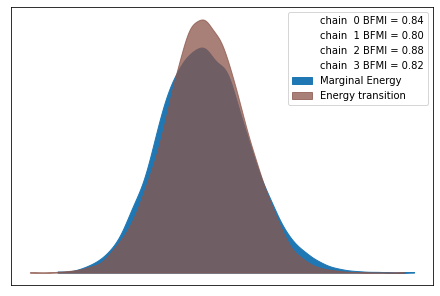

In [8]:
az.plot_energy(semipooled_idata)

In [9]:
# az.plot_trace(semipooled_idata)
# plt.savefig('/home/mclancy/truespikes/notebooks/figures/model_selection/bayesian_linear_regression/semipooled_traces.pdf')

In [10]:
with semipooled_model:

    # change the value and shape of the data
    pm.set_data(
        {
            "X_observed": X_test[GAUSSIAN_METRICS],
            "sorter_idx": X_test['sorter_id'].values,
            # use dummy values with the same shape:
            "y_observed": y_test
        }
    )
    post_pred = pm.sample_posterior_predictive(semipooled_idata.posterior)

In [11]:
y_preds = np.array([sample_pred.mean() for sample_pred in post_pred['agreement_score_likelihood'].T])

rescaled_y_preds = inverse_logit_transform(y_preds)
rescaled_y_test = inverse_logit_transform(y_test)

In [12]:
rmse = np.sqrt(mean_squared_error(rescaled_y_test, rescaled_y_preds))

print(rmse)

0.211499084774777


/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='agreement_score'>

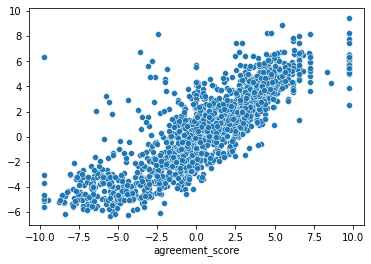

In [13]:
sns.scatterplot(y_test, y_preds)

<AxesSubplot:ylabel='Count'>

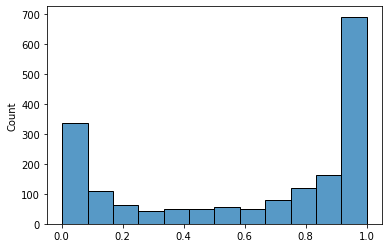

In [14]:
sns.histplot(rescaled_y_preds)

<AxesSubplot:xlabel='agreement_score', ylabel='Count'>

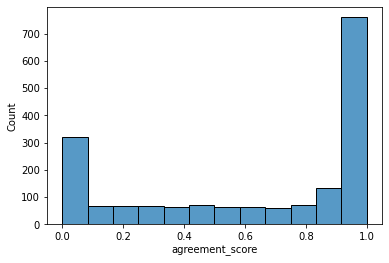

In [15]:
sns.histplot(rescaled_y_test)

In [29]:
fp_preds = y_preds >= 0.5
fp_test = y_test >= 0.5

In [30]:
f1_score(fp_preds, fp_test)

0.8807854137447406

In [31]:
semipooled_idata.posterior

<xarray.Dataset>
Dimensions:                         (chain: 4, draw: 2000, metric_names: 7, sorter_names: 6, agreement_score_estimate_dim_0: 7181)
Coordinates:
  * chain                           (chain) int64 0 1 2 3
  * draw                            (draw) int64 0 1 2 3 ... 1996 1997 1998 1999
  * metric_names                    (metric_names) object 'firing_rate' ... '...
  * sorter_names                    (sorter_names) object 'ironclust' ... 'tr...
  * agreement_score_estimate_dim_0  (agreement_score_estimate_dim_0) int64 0 ...
Data variables:
    weights_mu                      (chain, draw, metric_names) float32 0.233...
    bias_mu                         (chain, draw, metric_names) float32 0.339...
    weights_offset                  (chain, draw, sorter_names, metric_names) float32 ...
    bias_offset                     (chain, draw, sorter_names, metric_names) float32 ...
    weights_sigma                   (chain, draw, metric_names) float32 0.917...
    bias_sigma                      (chain, draw, metric_names) float32 0.803...
    weights                         (chain, draw, sorter_names, metric_names) float32 ...
    bias                            (chain, draw, sorter_names, metric_names) float32 ...
    agreement_score_estimate        (chain, draw, agreement_score_estimate_dim_0) float32 ...
    sigma                           (chain, draw) float32 1.934 1.89 ... 1.907
Attributes:
    created_at:                 2021-09-04T15:20:48.793059
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              3768.9502217769623
    tuning_steps:               2000